In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5324.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_3382.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1398.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1142.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5002.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_2646.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_3476.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1613.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5593.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_2975.BMP
/kaggle/input/finger-print-based-blood-g

In [3]:
pip install tenserflow

^C
Note: you may need to restart the kernel to use updated packages.


In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from collections import Counter
import numpy as np
import os
import shutil
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [33]:
dataset_path = "/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group"

In [35]:
BATCH_SIZE= 32

In [36]:
dataset = image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64,64),
    batch_size=BATCH_SIZE,
    shuffle=True
)


Found 6000 files belonging to 8 classes.


In [40]:
class_names =dataset.class_names
class_counts =Counter()
for _,labels in dataset.unbatch():
    class_counts[int(labels.numpy())] +=1
print("Class Distribution:")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")

Class Distribution:
A-: 1009
O-: 712
AB-: 761
B-: 741
O+: 852
B+: 652
AB+: 708
A+: 565


In [41]:
import matplotlib.pyplot as plt
def plot_class_distribution(class_names,class_counts):
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]
    plt.figure(figsize=(10,6))
    

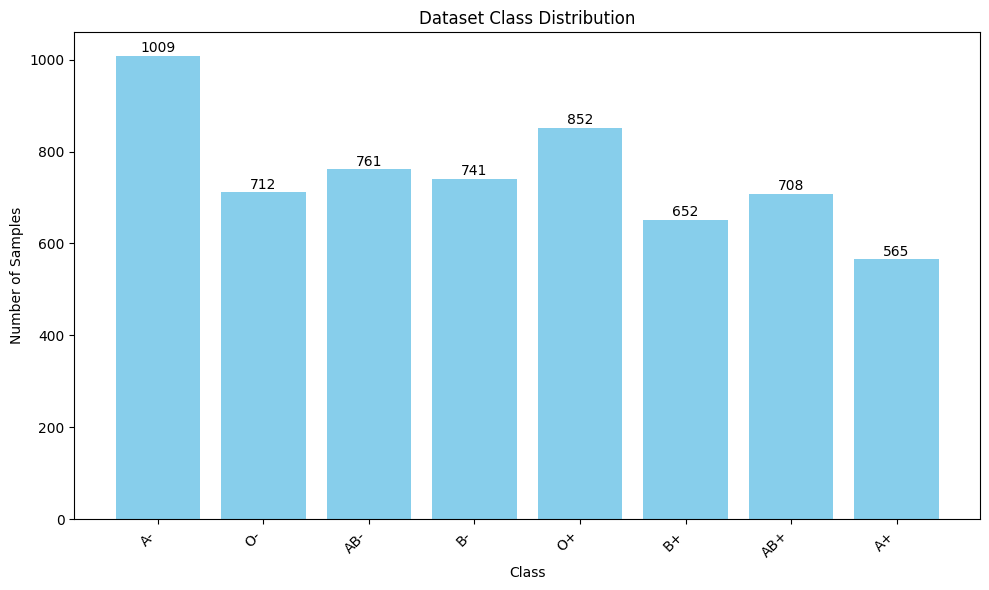

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(class_names, class_counts):
    """
    Plots the distribution of classes using a bar chart.

    Args:
        class_names (dict): A dictionary where keys are class indices (or any identifier)
                             and values are the corresponding class names (strings).
        class_counts (dict): A dictionary where keys are class indices (or any identifier)
                             and values are the corresponding counts.
    """
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title("Dataset Class Distribution")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping

    # Add value labels on top of the bars
    for i, count in enumerate(counts):
        plt.text(i, count + 1, str(count), ha='center', va='bottom')

    plt.show()

if __name__ == '__main__':


    plot_class_distribution(class_names, class_counts)

In [45]:
max_count= max(class_counts.values())

In [47]:
def oversample_class(class_id,count,max_count):
    unbatched_dataset = dataset.unbatch()
    class_dataset = unbatched_dataset.filter(lambda img,lbl:tf.equal(lbl,class_id))
    repeat_factor = max_count //count + (max_count % count >0)
    return class_dataset.repeat(repeat_factor).take(max_count)

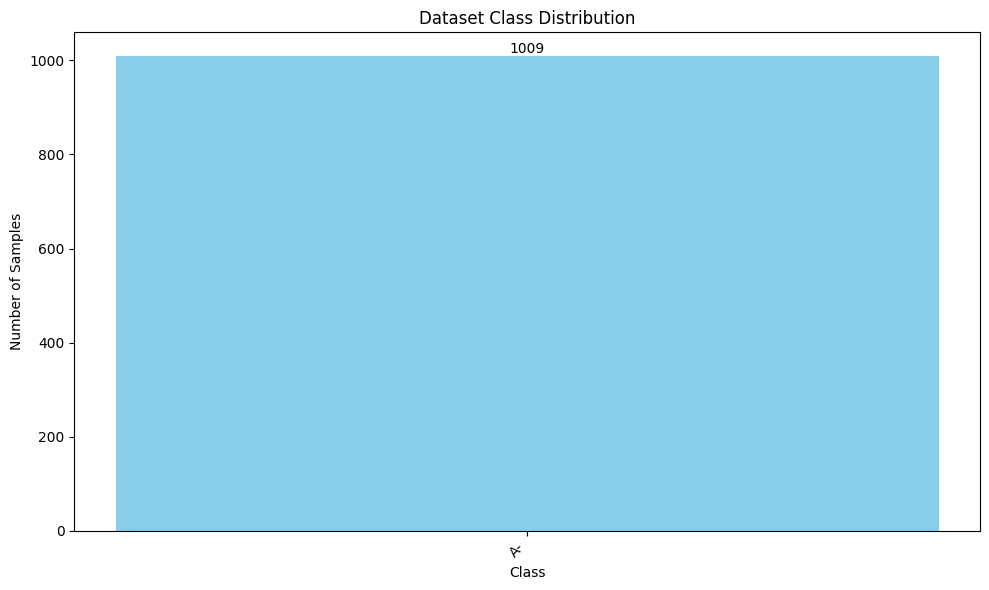

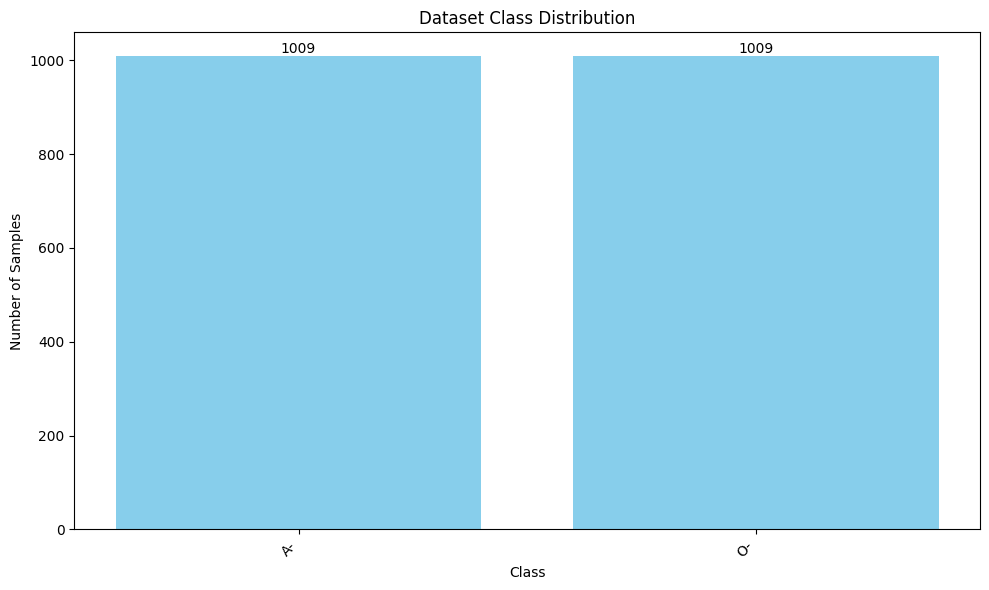

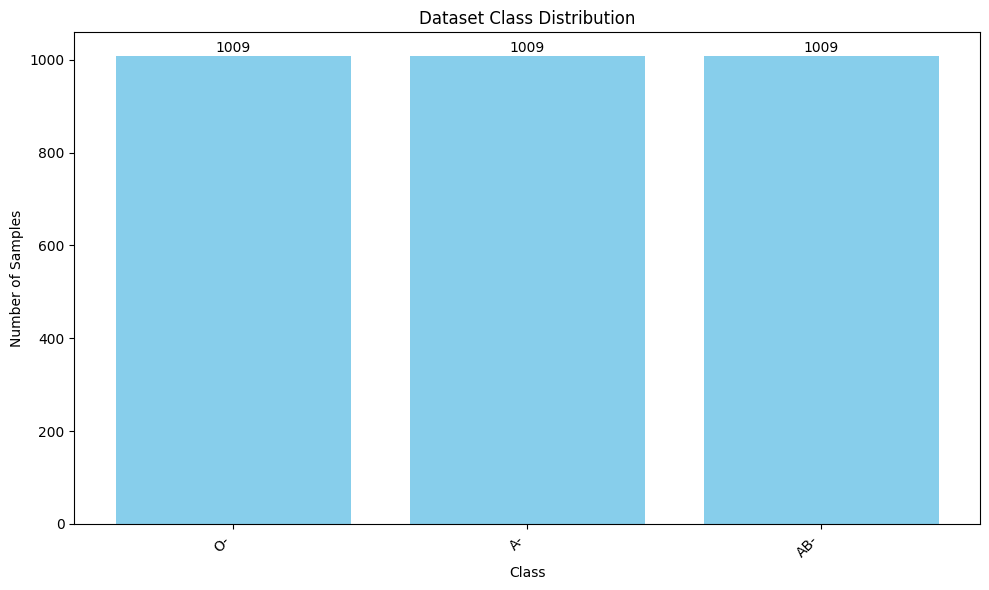

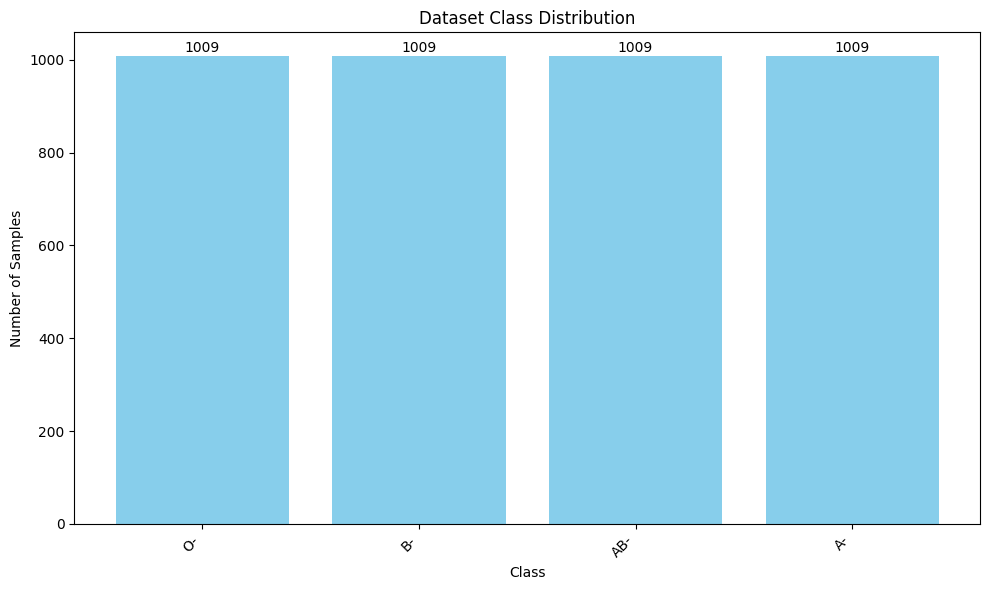

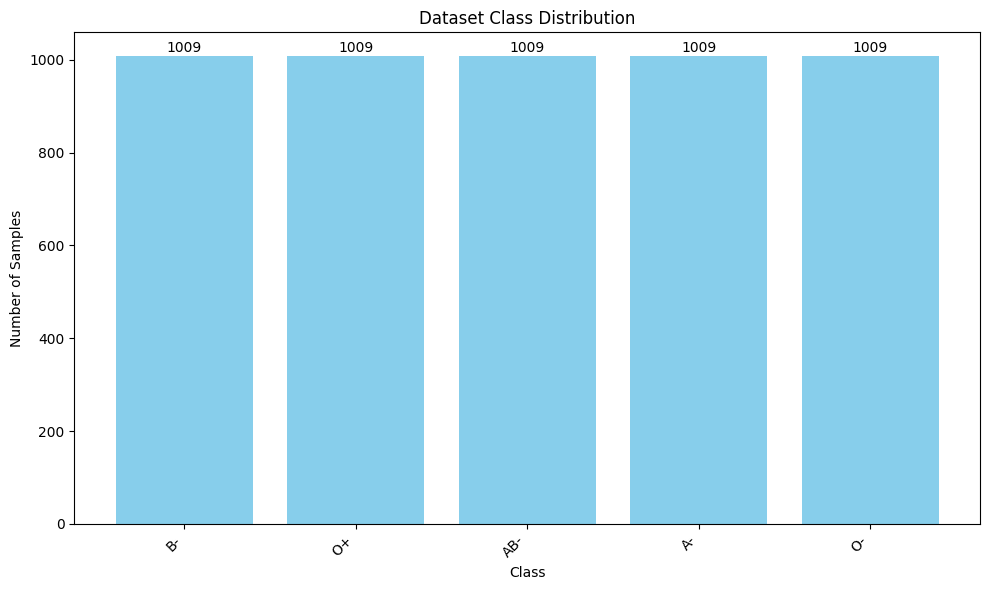

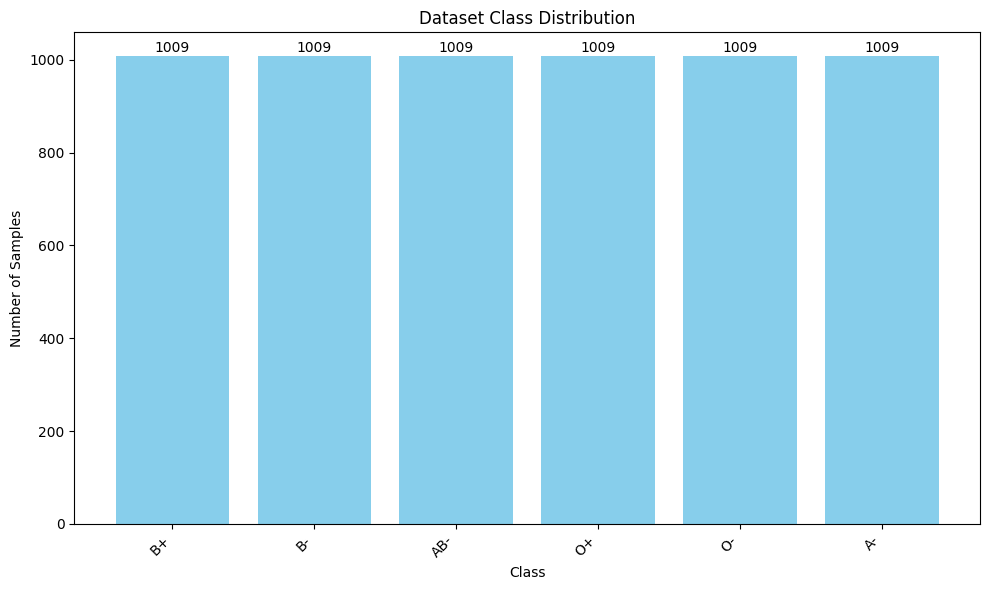

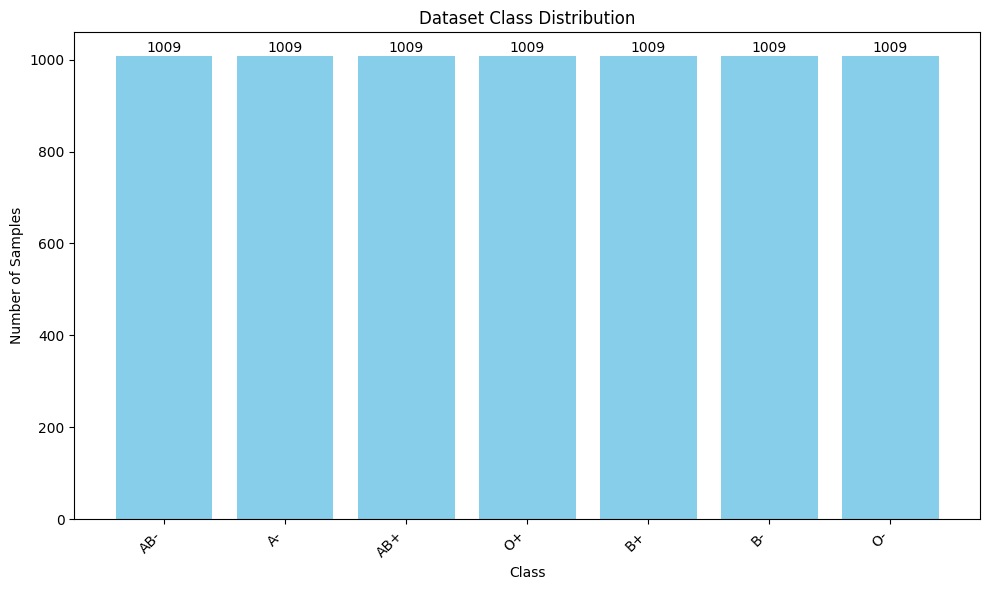

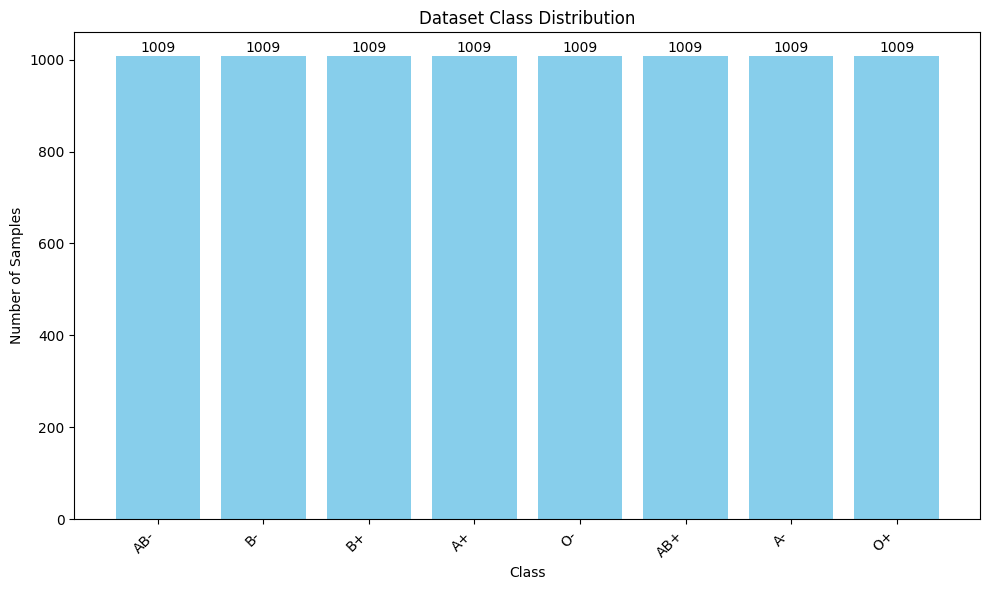

In [51]:
balanced_datasets=[]
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id,count,max_count))
    balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)
    balanced_class_counts= Counter([int(lbl.numpy()) for _,lbl in balanced_dataset])
    plot_class_distribution(class_names,balanced_class_counts)
    balanced_dataset = balanced_dataset.batch(BATCH_SIZE,drop_remainder=True)

In [52]:
for sample in balanced_dataset.take(10):
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [53]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size:{dataset_size}")

Total dataset size:8064


In [56]:
balanced_dataset_unbalanced = balanced_dataset.unbatch()
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
train_dataset = balanced_dataset_unbatched.take(train_size)
val_test_dataset = balanced_dataset_unbatched.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)
train_dataset = train_dataset.batch(BATCH_SIZE,drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE,drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE,drop_remainder=True)
train_batch_count=sum(1 for _ in train_dataset)
val_batch_count=sum(1 for _ in val_dataset)
test_batch_count=sum(1 for _ in test_dataset)
print(f"Training dataset size:{train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size:{val_batch_count * BATCH_SIZE}")
print(f"Testing dataset size:{test_batch_count * BATCH_SIZE}")

Training dataset size:5632
Validation dataset size:1600
Testing dataset size:800


In [58]:
def create_high_accuracy_model():
    model = tf.keras.model.Sequential([
        tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(64,64,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0,3),
        
        tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0,4),
        
        tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0,4),

        tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0,4),

        tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0,4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024,activation='relu'),
        tf.keras.layers.Dropout(0,5),

        tf.keras.layers.Dense(len(class_names),activation='softmax')
    ])
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model
    
high_acc_model = create_high_accuracy_model()

AttributeError: module 'tensorflow.keras' has no attribute 'model'

In [ ]:
import tensorflow as tf

def create_high_accuracy_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 3)),  # Define input shape here

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create the model
high_acc_model = create_high_accuracy_model()


In [66]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,  # Corrected "verboss" to "verbose"
    min_lr=1e-6
)

# Define EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Added missing comma after 'val_loss'
    verbose=1,  # Corrected "verboss" to "verbose"
    restore_best_weights=True
)


In [67]:
history_high_acc = high_acc_model.fit(
    train_dataset,
    validation_data= val_dataset,
    epochs=50,
    callbacks=[reduce_lr,early_stop]
)

Epoch 1/50
    176/Unknown 57s 305ms/step - accuracy: 0.1426 - loss: 33.0767

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


176/176 ━━━━━━━━━━━━━━━━━━━━ 74s 401ms/step - accuracy: 0.1428 - loss: 32.9393 - val_accuracy: 0.3131 - val_loss: 1.9698 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 70s 398ms/step - accuracy: 0.3848 - loss: 1.5896 - val_accuracy: 0.4700 - val_loss: 1.4604 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 70s 398ms/step - accuracy: 0.6117 - loss: 1.0795 - val_accuracy: 0.6661 - val_loss: 1.2613 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 68s 387ms/step - accuracy: 0.6555 - loss: 0.9519 - val_accuracy: 0.6924 - val_loss: 1.0570 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 70s 394ms/step - accuracy: 0.7006 - loss: 0.8148 - val_accuracy: 0.5717 - val_loss: 1.1945 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 69s 393ms/step - accuracy: 0.7361 - loss: 0.7424 - val_accuracy: 0.6244 - val_loss: 1.0607 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 69s 389ms/step - accuracy: 0.7271 - loss

In [69]:
high_acc_eval = high_acc_model.evaluate(val_dataset)
print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.9484 - loss: 0.2572
High Accuracy Model - Loss: 0.2586560845375061, Accuracy: 0.9221813678741455


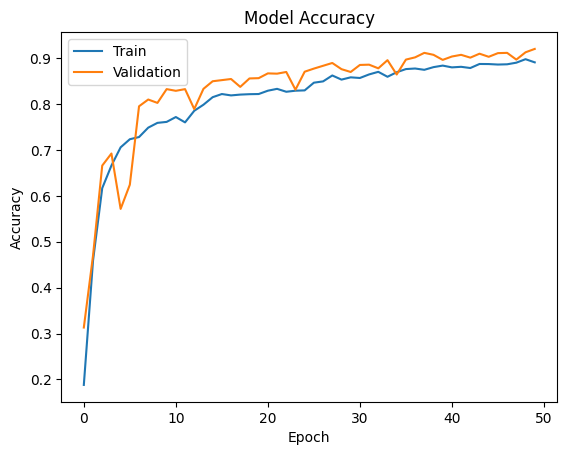

In [71]:
import matplotlib.pyplot as plt  # Fixed typo from "pit" to "plt"

# Plot training & validation accuracy values
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train')  # Added `label` for legend
    plt.plot(history.history['val_accuracy'], label='Validation')  # Added `label` for legend
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')  # Corrected the legend syntax
    plt.show()

# Call the function to display the accuracy graph
plot_accuracy(history_high_acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Classification Report:
              precision    

AttributeError: QuadMesh.set() got an unexpected keyword argument 'annots'

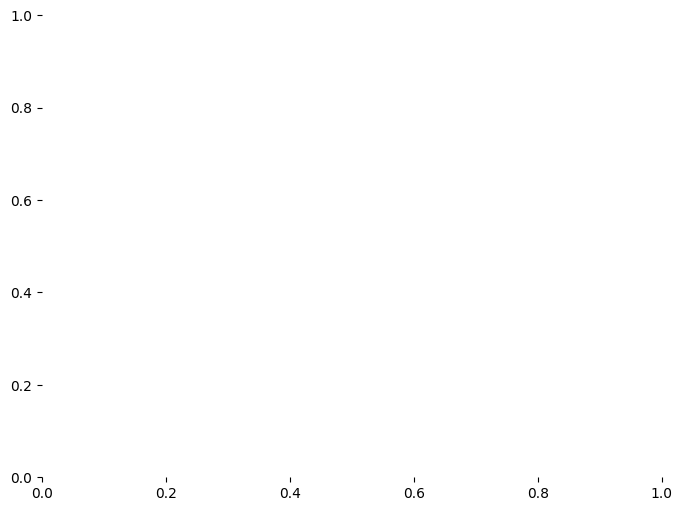

In [111]:
y_true= [] 
y_pred = [] #Predicted labels

#Iterate over the test dataset and collect the true and predicted labels

for images, labels in test_dataset:
    predictions= high_acc_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1) #Convert one-hat encoded predictions to class labels
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

#Convert tensor to numpy array and append

#Convert to numpy arrays

y_true = np.array(y_true)
y_pred = np.array(y_pred)
#Classification report

report = classification_report(y_true, y_pred, target_names=class_names)

print("Classification Report:")

print(report)

conf_matrix = confusion_matrix(y_true,y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,annots=True,cmaps='blues',xticklabels=class_names,yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylable('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Classification Report:
              precis

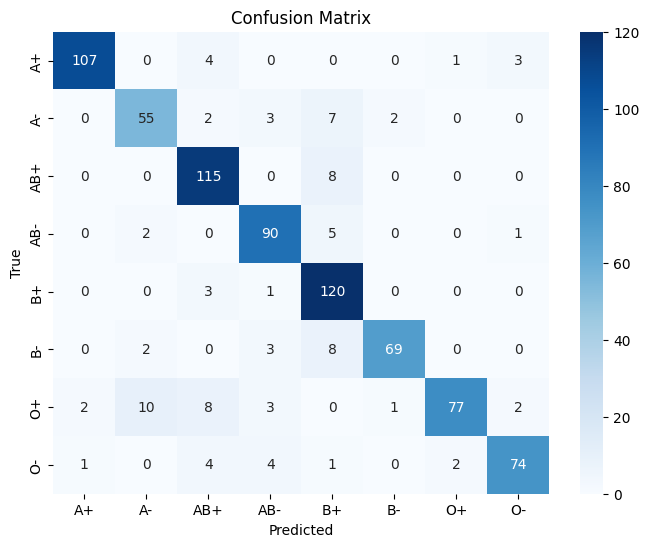

In [112]:
y_true = [] 
y_pred = []  # Predicted labels

# Iterate over the test dataset and collect the true and predicted labels
for images, labels in test_dataset:
    predictions = high_acc_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert one-hot encoded predictions to class labels
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [113]:
high_acc_model.save('model.h5')
print("Model saved as HDFS format")

Model saved as HDFS format
